In [ ]:
#Step 1: Install Dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

#Step 2: Add environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

#Step 3: Initialize Pyspark
import findspark
findspark.init()

In [ ]:
#creating spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
#spark = SparkSession.builder.appName('ml-random').getOrCreate()

In [ ]:
import pyspark
import random

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf 
from pyspark.sql.types import StructField,IntegerType, StructType,StringType, FloatType
from pyspark.sql.functions import desc 
from pyspark.sql.functions import asc 
import pyspark.sql.functions as F 

from pyspark.sql import Window
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import DateType
from pyspark.sql.functions import *
from pyspark.sql.functions import split
from pyspark.sql.functions import hour
from pyspark.sql.functions import date_format

In [ ]:
import numpy as np
import pandas as pd 
from datetime import datetime
from pyspark.sql import SparkSession

In [ ]:
!mkdir process

mkdir: cannot create directory ‘process’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths = ["/content/drive/MyDrive/Cloud Course Data/Project/CleanedDataset2/part1.csv", "/content/drive/MyDrive/Cloud Course Data/Project/CleanedDataset2/part2.csv"]
df=spark.read.option("header","true").csv(paths)
df.count()

171204

In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- first_trend_date: string (nullable = true)
 |-- last_trend_date: string (nullable = true)
 |-- published_date: string (nullable = true)
 |-- published_time: string (nullable = true)
 |-- publish_hour: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- commentcount: string (nullable = true)
 |-- diff_days: string (nullable = true)
 |-- trend_days: string (nullable = true)
 |-- tier: string (nullable = true)
 |-- trend: string (nullable = true)



In [ ]:
df.createOrReplaceTempView("video_table")
final_datset=spark.sql("select  video_id ,INT(category_id), DATE(first_trend_date), DATE(last_trend_date),\
DATE(published_date),published_time,INT(publish_hour),INT(views),INT(likes) ,INT(dislikes),INT(commentcount),\
INT(diff_days),INT(trend_days),tier,trend from video_table") 

In [ ]:
final_datset.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- first_trend_date: date (nullable = true)
 |-- last_trend_date: date (nullable = true)
 |-- published_date: date (nullable = true)
 |-- published_time: string (nullable = true)
 |-- publish_hour: integer (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- commentcount: integer (nullable = true)
 |-- diff_days: integer (nullable = true)
 |-- trend_days: integer (nullable = true)
 |-- tier: string (nullable = true)
 |-- trend: string (nullable = true)



In [ ]:
final_datset.columns

['video_id',
 'category_id',
 'first_trend_date',
 'last_trend_date',
 'published_date',
 'published_time',
 'publish_hour',
 'views',
 'likes',
 'dislikes',
 'commentcount',
 'diff_days',
 'trend_days',
 'tier',
 'trend']

In [ ]:
my_cols = final_datset.select(['video_id','category_id','views',
 'likes',
 'dislikes',
 'commentcount',
 'tier',
 'trend'
])

In [ ]:
my_final_data = my_cols.na.drop()

In [ ]:
my_final_data.groupby('tier').count().show() # imbalanced classes

+-----+------+
| tier| count|
+-----+------+
|tier1|148701|
|tier2| 22503|
+-----+------+



In [ ]:
my_final_data.groupby('trend').count().show() #imbalanced classes

+-----+------+
|trend| count|
+-----+------+
|  low|166530|
| high|  4674|
+-----+------+



In [ ]:
my_final_data_balanced1 = my_final_data.sample(False, 0.15, seed=123).where(my_final_data.tier == 'tier1')

In [ ]:
my_final_data_balanced1.count()

22574

In [ ]:
my_final_data_balanced2 = my_final_data.where(my_final_data.tier == 'tier2')
my_final_data_balanced2.count()

22503

In [ ]:
my_final_data_tier_balanced = my_final_data_balanced1.union(my_final_data_balanced2)
my_final_data_tier_balanced.count()

45077

In [ ]:
my_final_data_trend_balanced1 = my_final_data.sample(False, 0.03, seed=123).where(my_final_data.trend == 'low')
my_final_data_trend_balanced2 = my_final_data.where(my_final_data.trend == 'high')
my_final_data_trend_balanced = my_final_data_trend_balanced1.union(my_final_data_trend_balanced2)

In [ ]:
my_final_data_trend_balanced.count()

9616

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('randomforest').getOrCreate()

###Working with Categorical Columns
tier

#Predicting the number of days video will take to get on trending list with Classification # 

In [ ]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer, StandardScaler)
from pyspark.ml import Pipeline 

train_df, test_df = my_final_data.randomSplit([0.7, 0.3], seed=12)

In [ ]:
train_df.count()

119750

In [ ]:
test_df.count()

51454

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
indexer = StringIndexer(inputCol='tier',outputCol='label')
inputvariables = ['views',
 'likes',
 'dislikes',
 'commentcount'
 ]
dependentvaraible = "label"
assembler = VectorAssembler(inputCols=inputvariables,outputCol='features') #'tierVec'
standard_scaler = StandardScaler(inputCol='features', outputCol='scaledfeatures')

#logisticReg = LogisticRegression(labelCol=dependentvaraible, featuresCol="scaledfeatures")
rf = RandomForestClassifier(labelCol=dependentvaraible, featuresCol="scaledfeatures", numTrees=50, seed=42)
stages = [indexer,assembler,standard_scaler,rf]
pipeline = Pipeline(stages=stages) 
model = pipeline.fit(train_df)

In [ ]:
results = model.transform(test_df)

In [ ]:
results.show()

+-----------+-----------+-------+-----+--------+------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|   video_id|category_id|  views|likes|dislikes|commentcount| tier|trend|label|            features|      scaledfeatures|       rawPrediction|         probability|prediction|
+-----------+-----------+-------+-----+--------+------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|--6vcer7XYQ|         24| 414012| 2161|     331|         416|tier1|  low|  0.0|[414012.0,2161.0,...|[0.12998644355999...|[43.2687352523061...|[0.86537470504612...|       0.0|
|--728h8mnDY|         26|  39535| 2573|      51|         269|tier1|  low|  0.0|[39535.0,2573.0,5...|[0.01241271761722...|[43.4292717257078...|[0.86858543451415...|       0.0|
|--YgtVuvWGo|         10| 362391|21547|     356|         955|tier2|  low|  1.0|[362391.0,21547.0...|[0.11377911091501...|[43.

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(results)}")

mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(results)}")

Area under ROC curve: 0.6460219910271544
Accuracy: 0.8676876433319081


In [ ]:
# Create ParamGrid for Cross Validation
#rfparamGrid = (ParamGridBuilder()
#               .addGrid(rf.regParam, [0.1, 0.01])
#              .addGrid(rf.elasticNetParam ,[0.0, 0.5,1.0])
#               .build())
rfparamGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxDepth, [2, 5, 10])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rf.maxBins, [5, 10, 20])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

# Evaluate model
rfevaluator = MulticlassClassificationEvaluator()

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = rfparamGrid,
                    evaluator = bcEvaluator,
                    numFolds = 5,  parallelism = 4)

In [ ]:
cvModel = rfcv.fit(train_df)

In [ ]:
#random forest
# Use the model identified by the cross-validation to make predictions on the test dataset
cvPredDF = cvModel.transform(test_df)
 
# Evaluate the model's performance based on area under the ROC curve and accuracy 
print(f"Area under ROC curve: {bcEvaluator.evaluate(cvPredDF)}")
print(f"Accuracy: {mcEvaluator.evaluate(cvPredDF)}")

Area under ROC curve: 0.688311877038921
Accuracy: 0.8677459478369028


In [ ]:
print('test data (f1):', mcEvaluator.setMetricName('f1').evaluate(cvPredDF), "\n",
     'test data (weightedPrecision): ', mcEvaluator.setMetricName('weightedPrecision').evaluate(cvPredDF),"\n",
     'test data (weightedRecall): ', mcEvaluator.setMetricName('weightedRecall').evaluate(cvPredDF),"\n",
     'test data (accuracy): ', mcEvaluator.setMetricName('accuracy').evaluate(cvPredDF))

test data (f1): 0.8071802603076054 
 test data (weightedPrecision):  0.8235777653407327 
 test data (weightedRecall):  0.8677459478369028 
 test data (accuracy):  0.8677459478369028


In [ ]:
conf_mat = cvPredDF.select('label', 'prediction')
conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(label=0.0, prediction=0.0): 44624,
             Row(label=1.0, prediction=0.0): 6783,
             Row(label=1.0, prediction=1.0): 25,
             Row(label=0.0, prediction=1.0): 22})

#Predicting the number of days video will trend on trending list with Classification
#trend

In [ ]:
indexer = StringIndexer(inputCol='trend',outputCol='label')
inputvariables = ['views',
 'likes',
 'dislikes',
 'commentcount'
 ]
dependentvaraible = "label"
assembler = VectorAssembler(inputCols=inputvariables,outputCol='features') #'tierVec'
standard_scaler = StandardScaler(inputCol='features', outputCol='scaledfeatures')

#logisticReg = LogisticRegression(labelCol=dependentvaraible, featuresCol="scaledfeatures")
rf = RandomForestClassifier(labelCol=dependentvaraible, featuresCol="scaledfeatures", numTrees=50, seed=42)
stages = [indexer,assembler,standard_scaler,rf]
pipeline = Pipeline(stages=stages) 
model = pipeline.fit(train_df)

In [ ]:
results = model.transform(test_df)

In [ ]:
results.show()

+-----------+-----------+-------+-----+--------+------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|   video_id|category_id|  views|likes|dislikes|commentcount| tier|trend|label|            features|      scaledfeatures|       rawPrediction|         probability|prediction|
+-----------+-----------+-------+-----+--------+------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|--6vcer7XYQ|         24| 414012| 2161|     331|         416|tier1|  low|  0.0|[414012.0,2161.0,...|[0.12998644355999...|[49.0396494341980...|[0.98079298868396...|       0.0|
|--728h8mnDY|         26|  39535| 2573|      51|         269|tier1|  low|  0.0|[39535.0,2573.0,5...|[0.01241271761722...|[49.2255108565160...|[0.98451021713032...|       0.0|
|--YgtVuvWGo|         10| 362391|21547|     356|         955|tier2|  low|  0.0|[362391.0,21547.0...|[0.11377911091501...|[48.

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(results)}")

mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(results)}")

Area under ROC curve: 0.8527947967035823
Accuracy: 0.9733159715474016


In [ ]:
# Create ParamGrid for Cross Validation
#rfparamGrid = (ParamGridBuilder()
#               .addGrid(rf.regParam, [0.1, 0.01])
#              .addGrid(rf.elasticNetParam ,[0.0, 0.5,1.0])
#               .build())
rfparamGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxDepth, [2, 5, 10])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rf.maxBins, [5, 10, 20])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

# Evaluate model
rfevaluator = MulticlassClassificationEvaluator()

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = rfparamGrid,
                    evaluator = bcEvaluator,
                    numFolds = 5,  parallelism = 4)

In [ ]:
cvModel = rfcv.fit(train_df)

In [ ]:
#Random Forest
# Use the model identified by the cross-validation to make predictions on the test dataset
cvPredDF = cvModel.transform(test_df)
 
# Evaluate the model's performance based on area under the ROC curve and accuracy 
print(f"Area under ROC curve: {bcEvaluator.evaluate(cvPredDF)}")
print(f"Accuracy: {mcEvaluator.evaluate(cvPredDF)}")

Area under ROC curve: 0.8741396038694178
Accuracy: 0.973043883857426


In [ ]:
print('test data (f1):', mcEvaluator.setMetricName('f1').evaluate(cvPredDF), "\n",
     'test data (weightedPrecision): ', mcEvaluator.setMetricName('weightedPrecision').evaluate(cvPredDF),"\n",
     'test data (weightedRecall): ', mcEvaluator.setMetricName('weightedRecall').evaluate(cvPredDF),"\n",
     'test data (accuracy): ', mcEvaluator.setMetricName('accuracy').evaluate(cvPredDF))

test data (f1): 0.9654067559997518 
 test data (weightedPrecision):  0.9648374053843511 
 test data (weightedRecall):  0.973043883857426 
 test data (accuracy):  0.973043883857426


In [ ]:
conf_mat = cvPredDF.select('label', 'prediction')
conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(label=0.0, prediction=0.0): 49843,
             Row(label=1.0, prediction=0.0): 1223,
             Row(label=1.0, prediction=1.0): 224,
             Row(label=0.0, prediction=1.0): 164})

In [ ]:
cvPredDF.show()

+-----------+-----------+-------+-----+--------+------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|   video_id|category_id|  views|likes|dislikes|commentcount| tier|trend|label|            features|      scaledfeatures|       rawPrediction|         probability|prediction|
+-----------+-----------+-------+-----+--------+------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|--6vcer7XYQ|         24| 414012| 2161|     331|         416|tier1|  low|  0.0|[414012.0,2161.0,...|[0.12998644355999...|[49.0719172508478...|[0.98143834501695...|       0.0|
|--728h8mnDY|         26|  39535| 2573|      51|         269|tier1|  low|  0.0|[39535.0,2573.0,5...|[0.01241271761722...|[49.6193632411147...|[0.99238726482229...|       0.0|
|--YgtVuvWGo|         10| 362391|21547|     356|         955|tier2|  low|  0.0|[362391.0,21547.0...|[0.11377911091501...|[47.

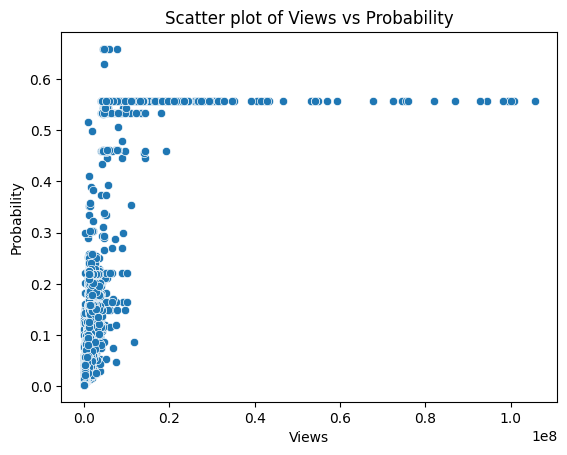

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = cvPredDF 
# select the columns to plot
plot_df = df.select("views", "probability")

# convert the Spark dataframe to a Pandas dataframe
plot_df = plot_df.toPandas()

# convert probability to a float
plot_df["probability"] = plot_df["probability"].apply(lambda x: float(x[1]))

# create the scatter plot
sns.scatterplot(data=plot_df, x="views", y="probability")

# set plot title and axis labels
plt.title("Scatter plot of Views vs Probability")
plt.xlabel("Views")
plt.ylabel("Probability")

# show the plot
plt.show()


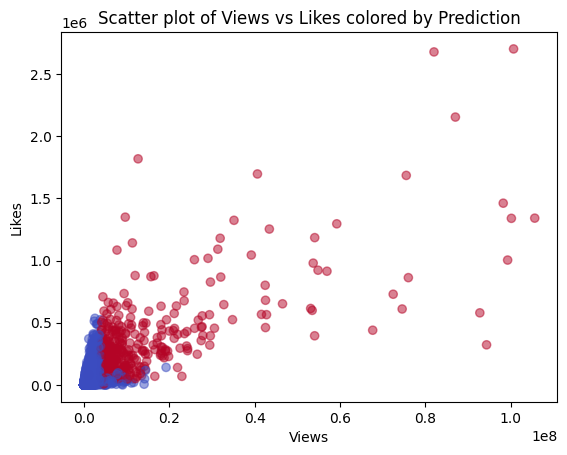

In [ ]:
# select the columns to plot
plot_df = df.select("views", "likes", "prediction")

# convert the Spark dataframe to a Pandas dataframe
plot_df = plot_df.toPandas()

# convert the columns to numeric type
plot_df["views"] = pd.to_numeric(plot_df["views"])
plot_df["likes"] = pd.to_numeric(plot_df["likes"])
plot_df["prediction"] = pd.to_numeric(plot_df["prediction"])

# create the scatter plot
plt.scatter(x=plot_df["views"], y=plot_df["likes"], c=plot_df["prediction"], cmap="coolwarm", alpha=0.5)

# set plot title and axis labels
plt.title("Scatter plot of Views vs Likes colored by Prediction")
plt.xlabel("Views")
plt.ylabel("Likes")

# show the plot
plt.show()
